# Elegant way to train your model, Using inferno based on pytorch
- Introduction: Inferno, pytorch, train model
- Installation
- Visualize data
    - Find internal structure
    - PCA
- Briefly introduce basic parts
    - Dataset, Dataloader
    - model
    - trainer
- Prepare to train
- Using pytorch to train mdoel
- Using inferno to train model (easier to write and reuse)

In this tutorial, I will take about how to build a deep learning network using pytorch step by step. The task I used is image classification. MNIST is used, a pretty small and useful dataset. It can help you get a good result without much fine-tuning and fancy methods.

If you want to get a better result by applying deep learning, you should get insights of your data as much as possible, which is always a data scientist should do. That's why I write lots of code to find data internal structure.

Besides, I will introduce an awesome library inferno based on pytorch, which is warpper library providing lots of useful utilites and functions. It simplifies the workflow of pytorch and provides simple inferface of writing logs to tensorboard.

If anything is not correct or clear to you, please contect me: `zeqiangh@andrew.cmu.edu`

# Installing the libraries

You can prepare your environment by applying this script. It may not be optimal, but it works.

**Note**: only tested on ubuntu.

```shell
# it assumes you have installed conda, and has matplotlib installed
# create conda environment
conda create -n tutorial python=3.6 numpy scipy panda
# activate the tutorial
source activate tutorial
conda install jupyter
# register this environment as a kernel
python -m ipykernel install --user --name tutorial --display-name "Python (tutorial)"

# if you do not need gpu support
conda install pytorch-cpu torchvision -c pytorch
conda install -c inferno-pytorch inferno

# install cpu version tensorflow is enough
pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-1.6.0-cp36-cp36m-linux_x86_64.whl

pip install sklearn
```

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms

from inferno.extensions.layers.reshape import Flatten
from inferno.trainers.basic import Trainer
from inferno.trainers.callbacks.logging.tensorboard import TensorboardLogger

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
# tested on torch.__version__ == 0.3.1.post2
torch.__version__

'0.3.1.post2'

# Load data
We will use a simple and popular dataset: MNIST, to finish our project. Pytorch has already included it so just run the following command, then everything is done.

Pytorch provides a build-in function `datasets.MNIST()` that can automatically download and process the dataset. The code below just download and process the MNIST data. You may be curious about what does 0.1307, 0.3081 means. It is the mean and std deviation of the MNIST dataset. ([further discussion](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457) if you want). Normalize your data is important because almost every deep learning method applys backpropagation and it requires axises(dimensions) have similar range. 

One more thing, test set/validation set should also use the mean and std deviation of **train set** to process normlization.

In [21]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

trainset = datasets.MNIST('./data', train=True, download=False,
                   transform=transform)
testset = datasets.MNIST('./data', train=False, transform=transform)

# actually, trainset is enough for pytorch to process, but,
# I want to show some visualization, thus it is more convient
# to define two extra variable. 
# Note: trainset[idx] gives you value after transform, while 
# trainset.train_data[idx] gives you value before transform
train_datas = trainset.train_data.numpy()
train_labels = trainset.train_labels.numpy()

print('length: trainset %d, testset %d' % (len(trainset), len(testset)))
print('data', train_datas.shape, ',label', train_labels.shape)

length: trainset 60000, testset 10000
data (60000, 28, 28) ,label (60000,)


# Visualize data

Once you decide to use deep learning to analysis you data, the very first thing you should is <b>visualize your data</b>.
There are lots of ways to do the job. Here is the way that I often uses.
- for image data
    - thumbnails (included)
    - hist of rgbs to see the distribution
- for speech
    - hist of utterance length
    - Mel power spectrogram
    - Mel mean spectrogram
- common
    - PCA (included)
    - TSNE

After you visualize your data, you may get more insight about how to design you model, because nowadays there is no sliver bullet of one-for-all model, so you have to carefully choose your model to fit your data.

## Images
### Basic Part
First let's get some most general insight, the code below displays 25 images drawn by matplotlib. For every image, its shape is $1*28*28$ (gray channel, height, width).

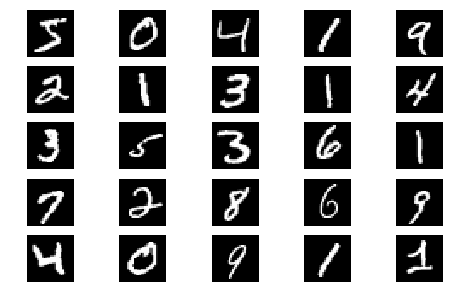

In [3]:
def plot_imgs(datas, labels):
    fig = plt.figure(figsize=(8,5))
    for i, (img, label) in enumerate(zip(datas, labels)):
        ax = fig.add_subplot(5, 5, i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i > 23:
            break
    plt.show()
plot_imgs(train_datas[:25], train_labels[:25])

## Mean of piexls
You may want to know, does all images that have same labels look alike? Here we use `mean` operation to see the result. The more light the pixel is, the larger value it is.

As a result, we are surprised that every label has same pattern, which is exactly the CNN tried to find. 

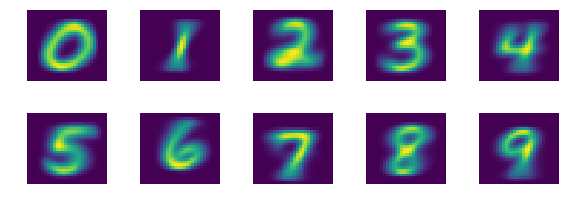

In [4]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    data = np.mean(train_datas[train_labels == i], axis=0)
    plt.imshow(data, aspect='auto')
    ax.axis('off')
plt.tight_layout()

## PCA
Principal Component Analysis, or PCA is a mathematical approach that works for convert high dimension variables to any dimension space you want. In other words, it can make projection. It can be also suit for dimensionality reduction without losing much information, because it trys to keep the highest possible variance in first principal component, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

It may hard to understand, we just need to know that it can perform dimensionality reduction and can detect distribution of data.

### Dimensionality reduction
For this section, we will exam that PCA will keep most information to perform reduction.

We are going to use excellect library sklearn, you just need to import library, then call `PCA(n_components)`, n_components represents the components (dimension space you want to project) you request.

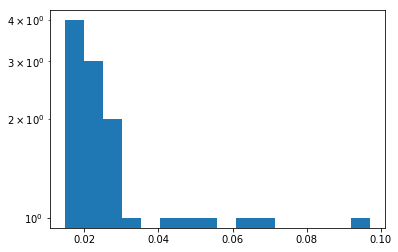

In [5]:
data = train_datas.reshape((-1, 28*28))
labels = train_labels

pca = PCA(n_components=16).fit(data)
plt.hist(pca.explained_variance_ratio_, bins=16, log=True)
plt.show()

### Distribution
We want to check the distribution of data, to get some insights.

As you can see, it does not cluster data perfectly, and it is expected. We are just looking for a good distribution of our data.



(60000, 784) (60000,) (60000, 2)


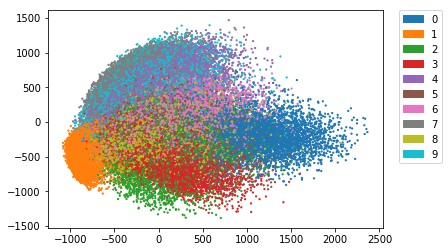

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
print(data.shape, labels.shape, pca_result.shape)
colorLookup = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 
               3:'tab:red', 4:'tab:purple', 5:'tab:brown', 6:'tab:pink', 7:'tab:gray', 8:'tab:olive', 9:'tab:cyan'}
colorLabels = [colorLookup[int(i)] for i in labels]
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colorLabels, s=1.5)
patches = [mpatches.Patch(color=c, label=str(key)) for key, c in colorLookup.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# What is basic workflow
Basically, in order to build a successfully model, what you need is to answer these questions: 

- where is your data from
- what is your model
- how to train your model step by step

## Where is your data from.

Pytorch provides an elegant representation of your data: `Dataset` and `Dataloader`. `Dataset` represents a total set of data (obviously) and `Dataloader` represent a batch of data. (`batch` means `a number of datas`, e.g. batch=32 means we will fetch 32 items once a time.)

### Dataset
You can treat dataset as an large array, which supports operation like getting item by index. Take a look at the defination of `Dataset`:

```python
class Dataset(object):
    def __getitem__(self, index):
        pass

    def __len__(self):
        pass

    def __add__(self, other):
        return ConcatDataset([self, other])
```
It is just an abstract class, right? You can inherit it and provide data by yourself. All subclasses should override __len__, that provides the size of the dataset, and __getitem__, supporting integer indexing in range from 0 to len(self) exclusive. We wil show examples below.

### Dataloader
You can treat dataloader as an iterator. For every step, you will get a batch of items. And it supports `shuffle` data (shuffle is really important in Deep Learning, if you do not shuffle your data, you will learn nothing, I suppose) and `multithread` which can speed up your program. Here is the way that what I offen use.
```python
DataLoader(dataset, batch_size, shuffle,**kwargs)
```

Official Documentation:
- [torch.utils.data](http://pytorch.org/docs/master/data.html)


Remember, we have used build-in function `datasets.MNIST('./data', train=True, download=True, transform=transform)` to get a dataset. So for now, we can just wrap it up with a `Dataloader`.

In [9]:
cuda = torch.cuda.is_available()
batch_size = 64

kwargs = {'num_workers': args.num_workers, 'pin_memory': True} \
    if cuda else {}

train_loader = DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=True,
        **kwargs)

test_loader = DataLoader(
        dataset=testset,
        batch_size=batch_size,
        shuffle=False,
        **kwargs)

### How to use Dataloader
You can just iterate through dataloader as below.

For every iteration, train_loader returns a tuple, (imgs, labels). The imgs shape is (batchsize, channel, height, width), and the labels shape is (batchsize)

In [10]:
for imgs, labels in train_loader:
    print('img shape %s, label shape: %s' % 
          (str(imgs.numpy().shape), str(labels.numpy().shape)))
    # if you want to print all of them, comment it.
    break 

img shape (64, 1, 28, 28), label shape: (64,)


## What is your model
When I first learn deep learning, I really get confused when designing model, for I have too many options to choose, and I have to make decision based on guess or wait two hours running to get results.

For now, unluckily, I still get confused (so sad). But I have gained a board and high-level understanding of it. Basically, layers are 'feature extractors', they can be used for detecting 'pattern' in input vector, like finding '1' in a 784 dim vector (22X22 image piexls). We can treat the layer's output as input of next layer. In this way, we build a network as deep as we can. And the last layer is a classifier to perform classification.

Convolution Neural Network is most popular network and widely used in image classification. The detailed explaination is beyond the scope of tutorial. I will reference a gif showing how to do the convolution calculation. Thanks to pytorch, we do not need to write boring code. Just add one line: `nn.Conv2d()`.

Here we build the model using pytorch. The model is from pytorch example. Use 2 conv layer, 1 dropout layer, 2 fully connected layer, and use relu as activation.

In [11]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Size([32, 1, 28, 28])
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # conv1's output channel is 10
        # Size([32, 10, 12, 12])
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Size([32, 20, 4, 4])
        x = x.view(-1, 320)
        # Size([32, 320])
        x = F.relu(self.fc1(x))
        # Size([32, 50])
        x = F.dropout(x, training=self.training)
        # Size([32, 50])
        x = self.fc2(x)
        # Size([32, 10])
        return x
    
model = Net()
if cuda:
    model = model.cuda()

## It's time to train your model
**Optimizer**: We will apply a simple but powerful optimizer: SGD with momentum, it may converge slower than others, but it also one of the most prevent optimizer people use.

Remember to use optimizer.zero_grad() to clear gradient at every batch, or you may get strange result.

Others can also be used, like Adam, RMSProp.

**Loss function**: CrossEntropyLoss will combine nn.LogSoftmax() and nn.NLLLoss() in one single class. It is more suitable for classification task.

After you send data to `model`, use loss function to calcuate loss, then backpropagation by `loss.backword()`.

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5,
                           momentum=0.5)
loss_fn = nn.CrossEntropyLoss()
# if you want more loss info, change it lower
log_interval = 100
epochs = 10

In [15]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += loss_fn(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(epochs):
    train(epoch+1)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.686029
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.332753
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.378387
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.403977
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.448496
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.198530
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.341127
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.425285
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.256629
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.458241

Test set: Average loss: 0.0019, Accuracy: 9649/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.293365
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.362668
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.309866
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.199664
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.455620
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.257119
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.357977
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.498207
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.309129
T

# Using inferno to refactor the code

In inferno, you just need to build a trainer and then provide you dataloader. It is done! Such a simple and clear way to use. The builder is easy to know by just see the function's name.

And it provides a clean way to monitor your network: tensorboard. It may require you install tensorflow before. It can automatically log results to tensorboard. You just need to start a new terminal and enter the `output` folder, then start tensorboard: `tensorboard --logdir='.'`

**save_directory**: For tensorboard uses. For every run, you should assign a new folder under 'output', like './output/1', './output/2'. Or your tensorboard will be confused.


In [ ]:
save_directory = './output/2'
def train_model():
    # Build trainer
    trainer = Trainer(model) \
        .build_criterion(loss_fn) \
        .build_metric('CategoricalError') \
        .build_optimizer(optimizer) \
        .validate_every((1, 'epochs')) \
        .save_every((2, 'epochs')) \
        .save_to_directory(save_directory) \
        .set_max_num_epochs(10) \
        .build_logger(TensorboardLogger(log_scalars_every=(10, 'iteration'),
                                        log_images_every='never'),
                      log_directory=save_directory)

    # Bind loaders
    trainer \
        .bind_loader('train', train_loader) \
        .bind_loader('validate', test_loader)

    if cuda:
        trainer.cuda()

    # Go!
    trainer.fit()

train_model()

### Result
You could see your result by enter url: `http://[your ip (or localhost)]:6006`

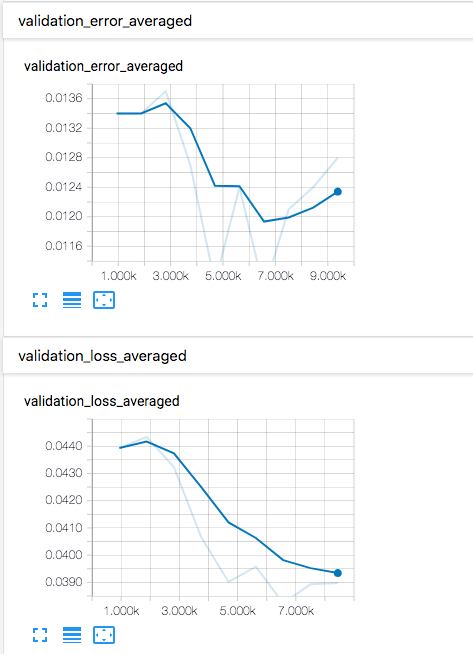

## Prediction

In [41]:
# predict by actual image
# it is really easy to change to your image if you want
# but ensure that images are only has gray channel,
# and size should be 28*28
def predict(img, label):
    prediction = model(Variable(img).view(-1,1, 28,28))
    print('your prediction is:', np.argmax(prediction.data.cpu().numpy()))
    print('actual label is:', label)
predict(*trainset[0])

your prediction is: 2
actual label is: 2


# Summary
For now, you should know how to train your model in a more 'data scientist way'. By which I mean, it is a lot better if you know your data. Also the code above is really easy to reuse, especially for inferno part. It encapsulates lots of details, you just need to tune hyperparameters.

If you think inferno encapsulates more than you needs, you can easily modify it by fork from github.

# Reference
- [pytorch](http://pytorch.org/docs/master/index.html)
- [inferno](https://github.com/inferno-pytorch/inferno)
- [PCA](https://www.kaggle.com/ddmngml/pca-and-svm-on-mnist-dataset/notebook)
- [CNN](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)